In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1️⃣ Load Dataset (Task 1: Data Preparation)
df = pd.read_excel("heart_disease.xlsx")
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head())

✅ Dataset Loaded Successfully!
Shape: (12, 2)
        age                                       Age in years
0    Gender                       Gender ; Male - 1, Female -0
1        cp                                    Chest pain type
2  trestbps                             Resting blood pressure
3      chol                                cholesterol measure
4       fbs  (fasting blood sugar > 120 mg/dl) (1 = true; 0...


***Data Cleaning and Feature Engineering***

In [19]:

# 2️⃣ Basic Cleaning
df.columns = df.columns.str.strip()  # remove extra spaces
df = df.dropna(how="all").dropna(axis=1, how="all")  # drop fully empty rows/cols

# Identify the target before imputation/encoding for later use
if len(df.columns) > 1:
    target_col = df.columns[-1]
else:
    target_col = None # Safety check

# Fill missing numeric with median, categorical with mode
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\n✅ Missing values handled!")




✅ Missing values handled!


In [20]:
# 3️⃣ Encode categorical columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
if cat_cols:
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    print("✅ Categorical columns encoded!")

✅ Categorical columns encoded!



***EDA***


🔎 Performing EDA Visualizations...


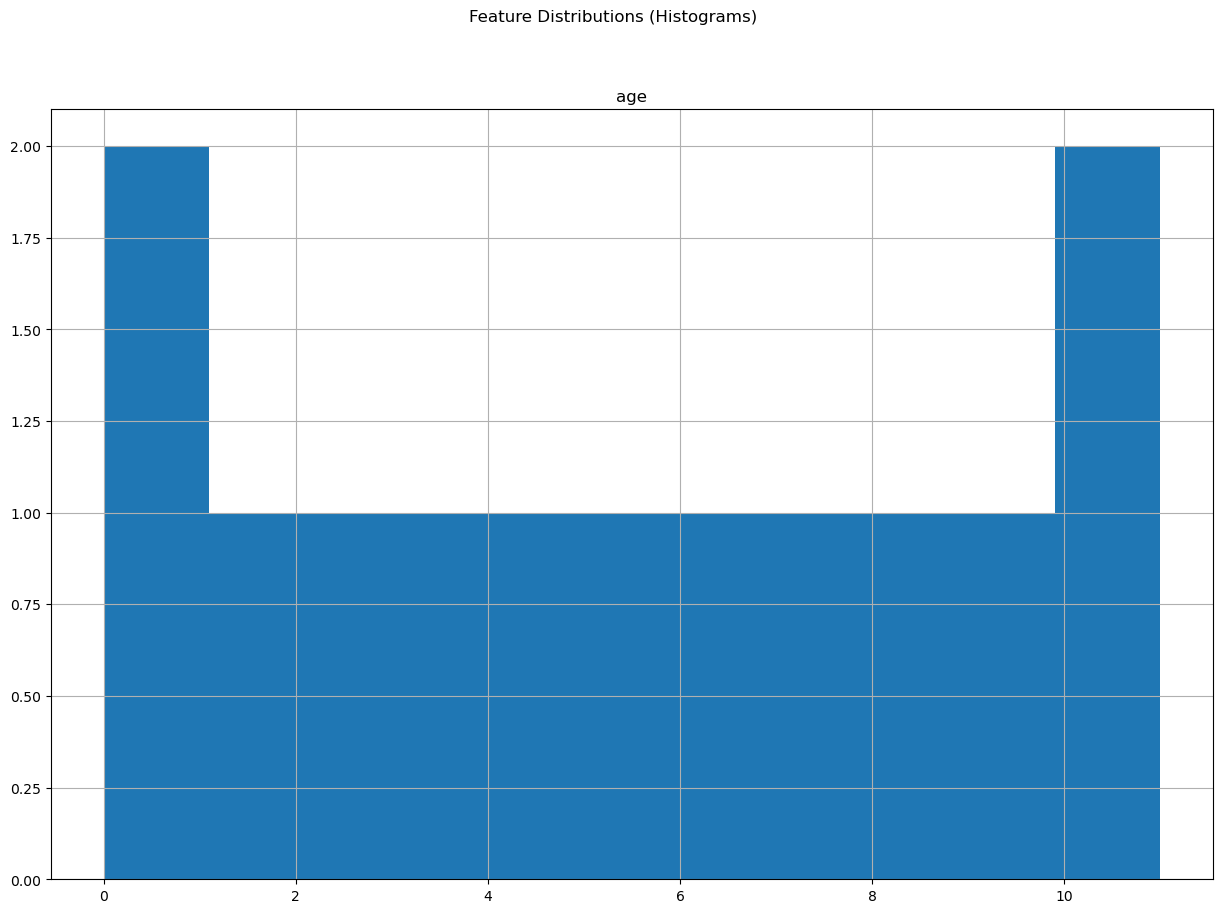

In [21]:

if target_col and len(df) > 0:
    print("\n🔎 Performing EDA Visualizations...")

    # 1. Feature Distributions
    df.drop(columns=[target_col], errors='ignore').hist(figsize=(15, 10), bins=10)
    plt.suptitle("Feature Distributions (Histograms)")
    plt.show()
    


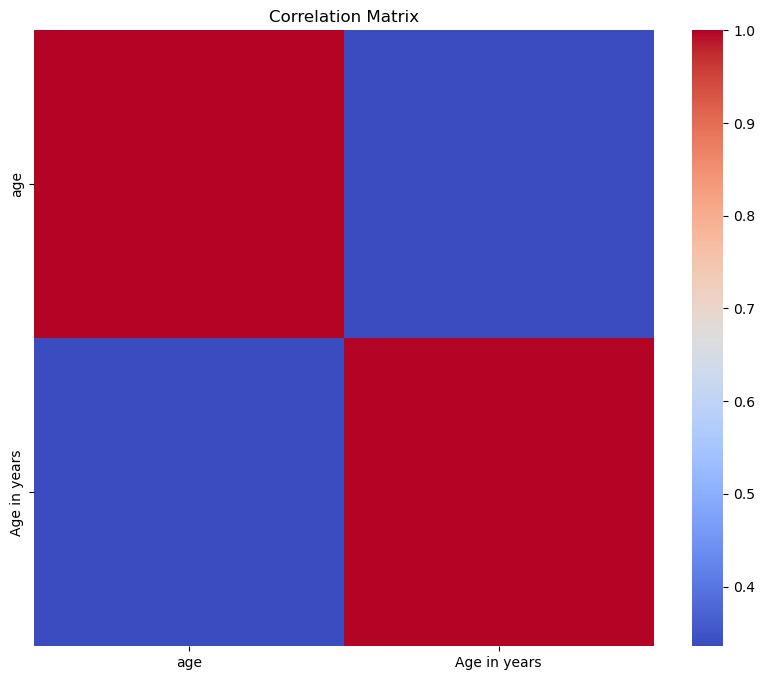

In [22]:

    # 2. Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()
    

    

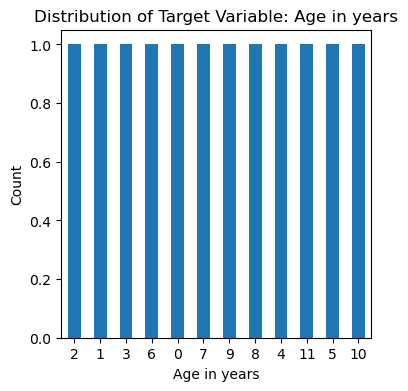

✅ EDA Visualizations Complete!


In [23]:
# 3. Class Distribution
plt.figure(figsize=(4, 4))
df[target_col].value_counts().plot(kind='bar')
plt.title(f"Distribution of Target Variable: {target_col}")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print("✅ EDA Visualizations Complete!")

***Model Preparation and Training***

In [24]:
# 4️⃣ Define X and y
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\nTarget column: {target_col}")
print("Class distribution:\n", y.value_counts())

# 5️⃣ Scale features (Task 3: Feature Engineering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ Train-test split (Safe mode)
if y.nunique() > 1 and all(y.value_counts() > 1):
    stratify_opt = y
else:
    print("⚠️ Not enough samples per class — skipping stratify.")
    stratify_opt = None

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=stratify_opt
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Target column: Age in years
Class distribution:
 Age in years
2     1
1     1
3     1
6     1
0     1
7     1
9     1
8     1
4     1
11    1
5     1
10    1
Name: count, dtype: int64
⚠️ Not enough samples per class — skipping stratify.
Train shape: (9, 1)
Test shape: (3, 1)



✅ Base Decision Tree Trained!
Accuracy: 0.0

Classification Report (Base Model):
               precision    recall  f1-score   support

           2       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



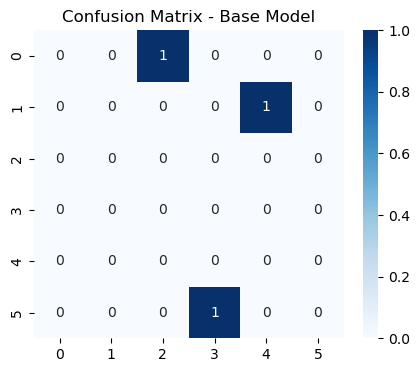

In [25]:
# 7️⃣ Train Base Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("\n✅ Base Decision Tree Trained!")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Base Model):\n", classification_report(y_test, y_pred))

# Confusion Matrix (Base Model)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Base Model")
plt.show()

***Hyperparameter Tuning and Final Evaluation***

In [26]:
# 8️⃣ Hyperparameter Tuning (Task 5)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# Run GridSearch safely
if len(y_train) > 10 and y_train.nunique() > 1:
    safe_cv = min(3, len(y_train))  # at most 3 folds for safety
    try:
        grid = GridSearchCV(
            DecisionTreeClassifier(random_state=42),
            param_grid,
            cv=safe_cv,
            scoring='accuracy',
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("\n✅ GridSearch Successful!")
        print("Best Params:", grid.best_params_)
    except Exception as e:
        print("⚠️ GridSearchCV failed — using base model. Error:", e)
        best_model = dt
else:
    print("⚠️ Dataset too small for GridSearchCV — using base model.")
    best_model = dt

⚠️ Dataset too small for GridSearchCV — using base model.



✅ Final Model Evaluation (Tuned Model):
Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



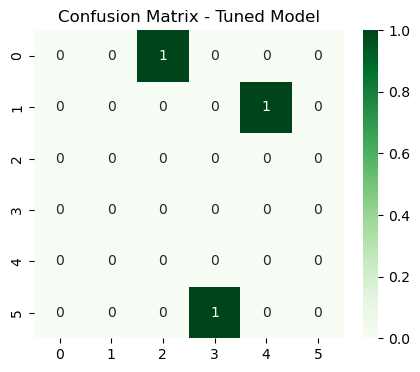

In [27]:
# 9️⃣ Evaluate Best Model (Task 6)
y_pred_best = best_model.predict(X_test)

print("\n✅ Final Model Evaluation (Tuned Model):")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Confusion Matrix (Tuned Model)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Tuned Model")
plt.show()

***Decision Tree Visualization***

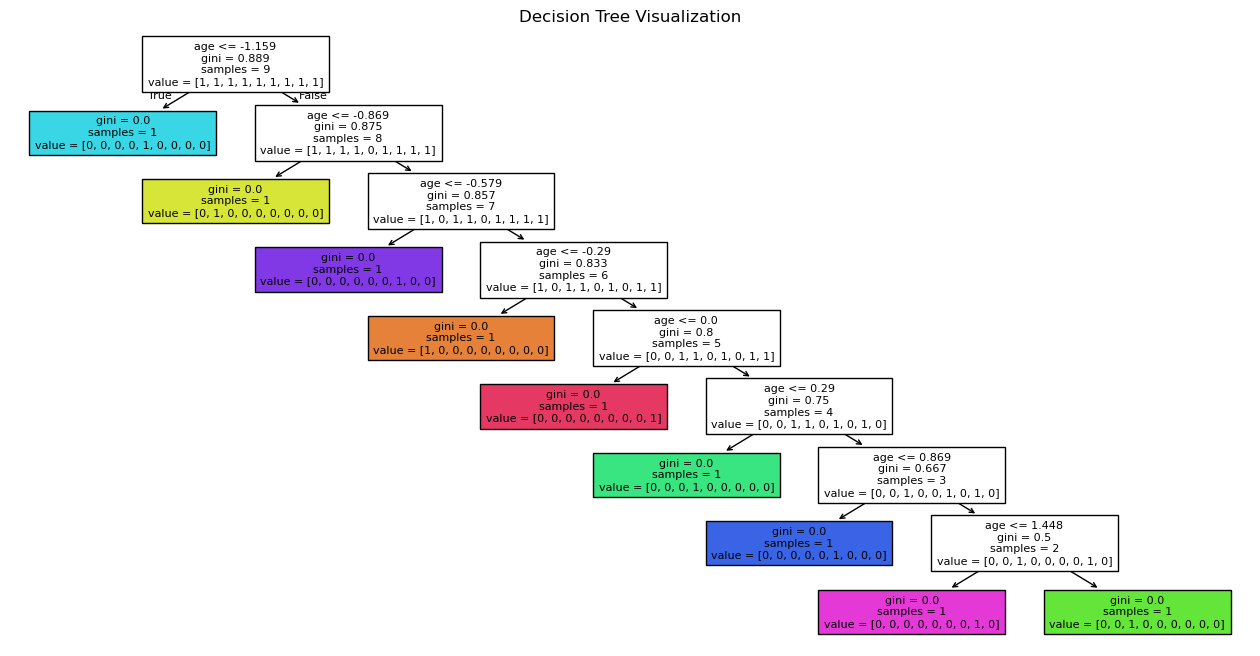

In [28]:
# 🔟 Decision Tree Visualization
plt.figure(figsize=(16,8))
plot_tree(best_model, feature_names=X.columns.tolist(), filled=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

***Interview que***

***Common Hyperparameters of Decision Tree Models***

Decision Tree hyperparameters control the complexity of the tree to prevent overfitting or underfitting:

***criterion:***

Defines the function used to measure the quality of a split.

Common choices are Gini impurity or Information Gain (based on entropy).

This choice influences how the algorithm selects the best feature and threshold for splitting a node.

***max_depth:***

Sets the maximum depth the tree can grow from the root node.

A high value can lead to overfitting (high variance) as the model learns the training data's noise.

A low value can lead to underfitting (high bias) by oversimplifying the decision boundaries.

***min_samples_split:***

Specifies the minimum number of samples a node must contain before it can be considered for splitting.

Increasing this value helps prune the tree and smooth the decision boundaries, which helps reduce overfitting.

***min_samples_leaf:***

Specifies the minimum number of samples required to be present at a terminal node (leaf).

This ensures that leaves are not based on very few observations, making the model more robust and reducing overfitting.

***max_features:***

Defines the number of features to consider when looking for the best split at each node.

Setting this to a value less than the total number of features introduces randomness and is particularly useful for creating diverse trees in ensemble methods like Random Forest.

***Label Encoding vs. One-Hot Encoding***